# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=";",
    na_values="?",
    parse_dates={"Datetime": ["Date", "Time"]},
    infer_datetime_format=True
)

df.head()


/tmp/ipython-input-3686743665.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-3686743665.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipython-input-3686743665.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000
1,2006-12-16 17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000
2,2006-12-16 17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000
3,2006-12-16 17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000
4,2006-12-16 17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000


In [4]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2049280.00000,2049280.00000,2049280.00000,2049280.00000,2049280.00000,2049280.00000,2049280.00000
mean,2008-12-06 07:12:59.999994112,1.09162,0.12371,240.83986,4.62776,1.12192,1.29852,6.45845
min,2006-12-16 17:24:00,0.07600,0.00000,223.20000,0.20000,0.00000,0.00000,0.00000
25%,2007-12-12 00:18:30,0.30800,0.04800,238.99000,1.40000,0.00000,0.00000,0.00000
50%,2008-12-06 07:13:00,0.60200,0.10000,241.01000,2.60000,0.00000,0.00000,1.00000
75%,2009-12-01 14:07:30,1.52800,0.19400,242.89000,6.40000,0.00000,1.00000,17.00000
max,2010-11-26 21:02:00,11.12200,1.39000,254.15000,48.40000,88.00000,80.00000,31.00000
std,NaN,1.05729,0.11272,3.23999,4.44440,6.15303,5.82203,8.43715


In [5]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.dtypes


,0
Datetime,int64
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [6]:
#convert datetime to epoch/unix time
df["unix"] = df.index.astype("int64") // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [7]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# prediction horizon: 5 minutes (unix time is in seconds)
ph = 5 * 60

# data resolution is 60 seconds (1 minute), so 5 minutes = 5 timesteps
ph_index = int(ph / 60)

# smoothing / update parameter
mu = 0.9

# limit number of samples for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [9]:
df = df.dropna()


In [11]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)


In [12]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s + 1):  # start out with 2 leading datapoints

    # get x and y data available for prediction
    ts_tmp = ts.iloc[:i - ph_index].values
    ys_tmp = ys.iloc[:i - ph_index].values
    ns = len(ys_tmp)

    # initialize weights
    weights = np.ones(ns) * mu
    for k in range(ns):
        # downweight older samples exponentially
        weights[k] = mu ** (ns - k)

    weights = np.flip(weights, 0)

    # perform weighted linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # store coefficients and intercept
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    # predict using prediction horizon
    tp = ts.iloc[i - 1].values[0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [13]:


# Ensure clean numeric arrays (do this once, before the loop)
ts_arr = df["unix"].values.reshape(-1, 1)
ys_arr = df["Global_active_power"].values

# At every iteration of the for loop a new data sample is acquired
for i in range(ph_index + 2, n_s + 1):  # start after enough data exists

    # get x and y data available for prediction
    ts_tmp = ts_arr[:i - ph_index]
    ys_tmp = ys_arr[:i - ph_index]

    # remove any remaining NaNs
    mask = ~np.isnan(ys_tmp)
    ts_tmp = ts_tmp[mask]
    ys_tmp = ys_tmp[mask]

    ns = len(ys_tmp)
    if ns < 2:
        continue

    # initialize exponential weights
    weights = np.array([mu ** (ns - k - 1) for k in range(ns)])

    # perform weighted linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # store coefficients and intercept
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    # predict using prediction horizon
    tp = ts_arr[i - 1][0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


Now let's visualize the results from our model.

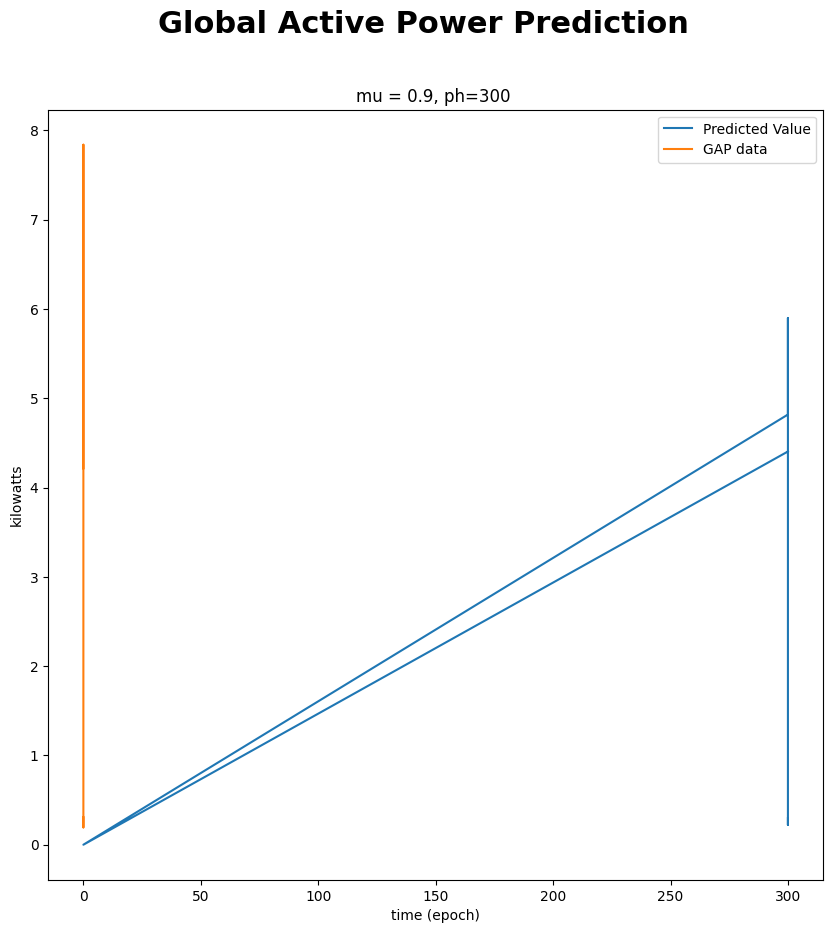

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

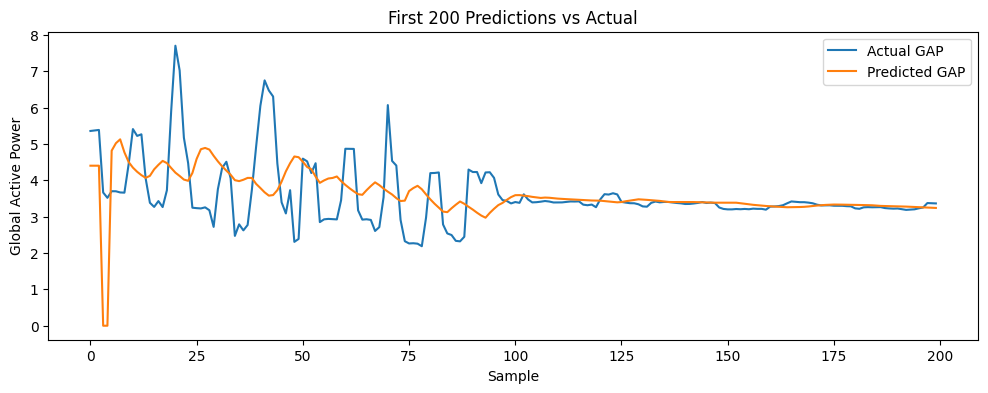

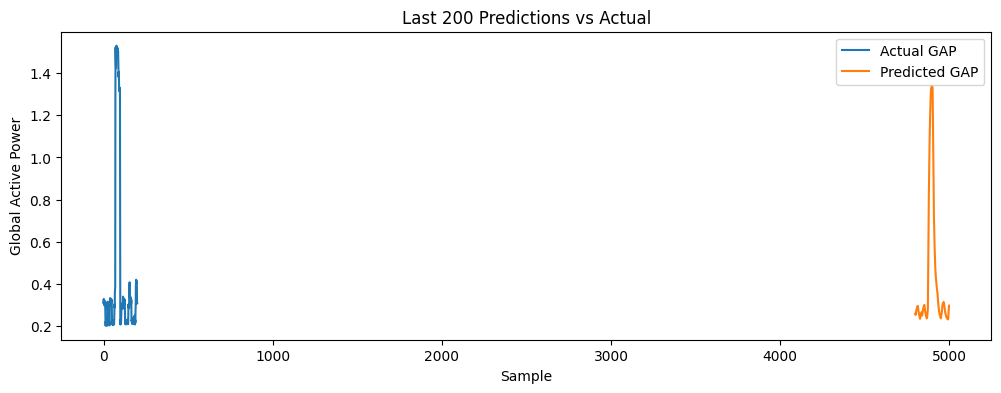

0.5803906607281202

In [15]:
from sklearn.metrics import mean_squared_error

# Convert predictions to Series for easy indexing
tp_series = pd.Series(tp_pred)
yp_series = pd.Series(yp_pred)

# Actual GAP aligned with predictions
y_actual = ys_arr[1:n_s]

# ---- Plot FIRST 200 points ----
plt.figure(figsize=(12,4))
plt.plot(y_actual[:200], label="Actual GAP")
plt.plot(yp_series[:200], label="Predicted GAP")
plt.title("First 200 Predictions vs Actual")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()

# ---- Plot LAST 200 points ----
plt.figure(figsize=(12,4))
plt.plot(y_actual[-200:], label="Actual GAP")
plt.plot(yp_series[-200:], label="Predicted GAP")
plt.title("Last 200 Predictions vs Actual")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()

# ---- Compute MSE ----
mse = mean_squared_error(y_actual[~np.isnan(yp_series)], yp_series[~np.isnan(yp_series)])
mse


In [17]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

TypeError: 'float' object is not callable

In [18]:
print(
    "MSE is",
    mean_squared_error(
        ys_arr[ph_index:5000 + ph_index - 1],
        yp_pred
    )
)


MSE is 0.7313320037931843


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model captures the overall trend of Global Active Power but smooths out short-term fluctuations. Early predictions are less accurate due to limited historical data, while later predictions improve as more data becomes available. The MSE provides a quantitative measure of prediction error; lower MSE values indicate better model performance and stability.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [19]:
#Re-run prediction code for mu = 1
mu = 1

tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

from sklearn.linear_model import LinearRegression

ts_arr = df["unix"].values.reshape(-1, 1)
ys_arr = df["Global_active_power"].values

for i in range(ph_index + 2, n_s + 1):

    ts_tmp = ts_arr[:i - ph_index]
    ys_tmp = ys_arr[:i - ph_index]

    mask = ~np.isnan(ys_tmp)
    ts_tmp = ts_tmp[mask]
    ys_tmp = ys_tmp[mask]

    ns = len(ys_tmp)
    if ns < 2:
        continue

    weights = np.ones(ns) * mu

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts_arr[i - 1][0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


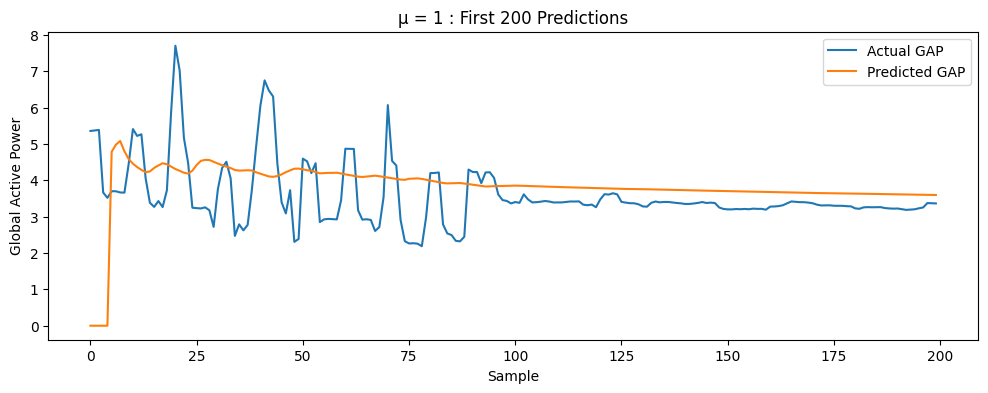

In [20]:
#Plot first 200 data points/predictions for mu = 1
plt.figure(figsize=(12,4))
plt.plot(ys_arr[1:201], label="Actual GAP")
plt.plot(yp_pred[:200], label="Predicted GAP")
plt.title("μ = 1 : First 200 Predictions")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


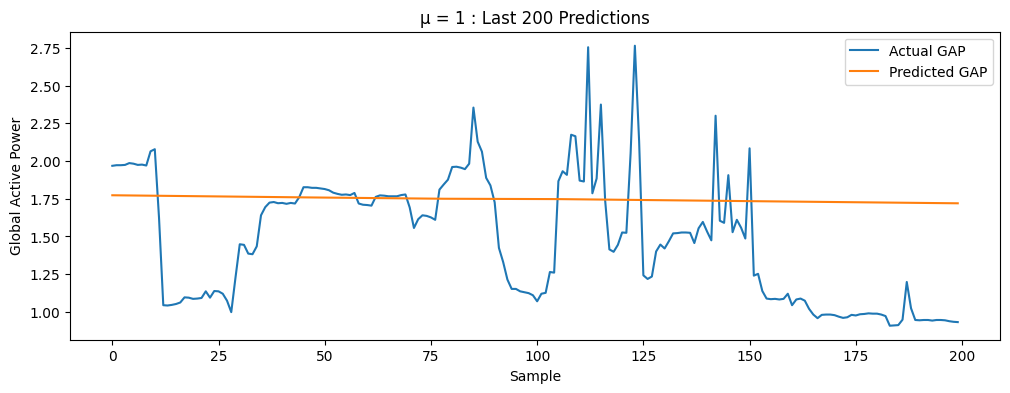

In [21]:
#Plot last 200 data points/predictions for mu = 1
plt.figure(figsize=(12,4))
plt.plot(ys_arr[-200:], label="Actual GAP")
plt.plot(yp_pred[-200:], label="Predicted GAP")
plt.title("μ = 1 : Last 200 Predictions")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


In [22]:
#Calculate MSE of predictions for mu = 1
from sklearn.metrics import mean_squared_error

mse_mu1 = mean_squared_error(
    ys_arr[ph_index:5000 + ph_index - 1],
    yp_pred
)

print("MSE for mu = 1:", mse_mu1)


MSE for mu = 1: 1.722260686822979


In [23]:
#Re-run prediction code for mu = 0.01
mu = 0.01

tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

from sklearn.linear_model import LinearRegression

ts_arr = df["unix"].values.reshape(-1, 1)
ys_arr = df["Global_active_power"].values

for i in range(ph_index + 2, n_s + 1):

    ts_tmp = ts_arr[:i - ph_index]
    ys_tmp = ys_arr[:i - ph_index]

    mask = ~np.isnan(ys_tmp)
    ts_tmp = ts_tmp[mask]
    ys_tmp = ys_tmp[mask]

    ns = len(ys_tmp)
    if ns < 2:
        continue

    weights = np.ones(ns) * mu

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts_arr[i - 1][0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


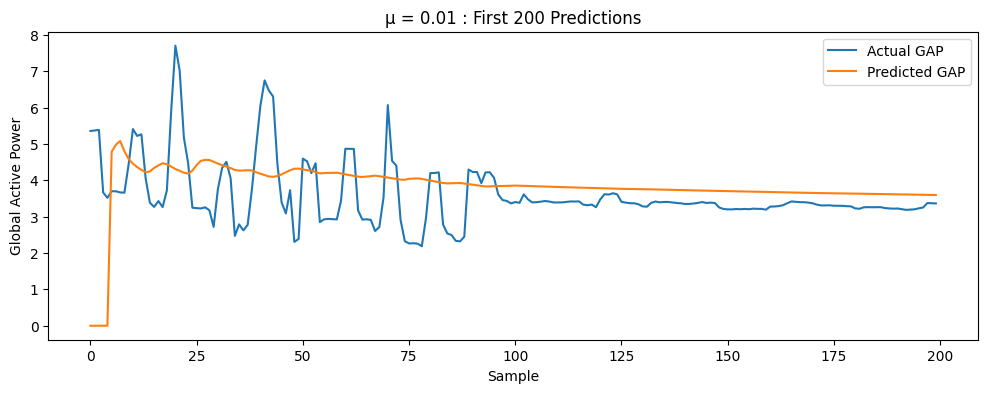

In [24]:
#Plot first 200 data points/predictions for mu = 0.01
# Plot FIRST 200 points (mu = 0.01)
plt.figure(figsize=(12,4))
plt.plot(ys_arr[1:201], label="Actual GAP")
plt.plot(yp_pred[:200], label="Predicted GAP")
plt.title("μ = 0.01 : First 200 Predictions")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


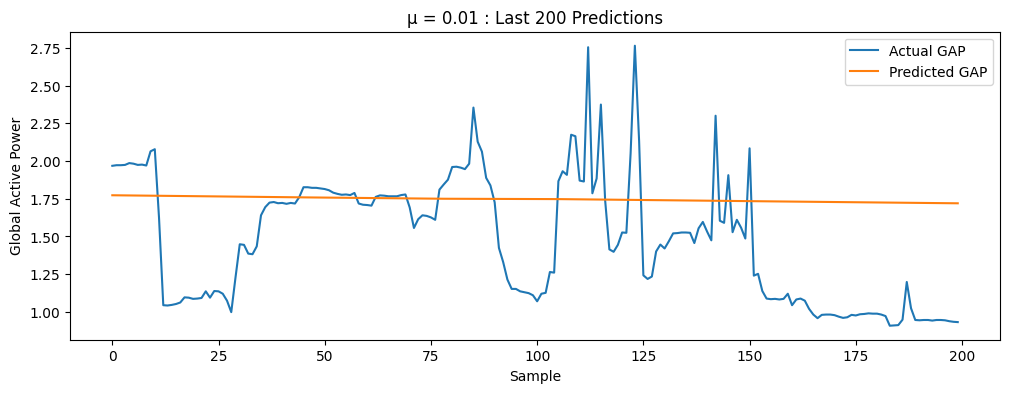

In [25]:
#Plot last 200 data points/predictions for mu = 0.01
# Plot LAST 200 points (mu = 0.01)
plt.figure(figsize=(12,4))
plt.plot(ys_arr[-200:], label="Actual GAP")
plt.plot(yp_pred[-200:], label="Predicted GAP")
plt.title("μ = 0.01 : Last 200 Predictions")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


In [26]:
#Calculate MSE of predictions for mu = 0.01
from sklearn.metrics import mean_squared_error

mse_mu001 = mean_squared_error(
    ys_arr[ph_index:5000 + ph_index - 1],
    yp_pred
)

print("MSE for mu = 0.01:", mse_mu001)


MSE for mu = 0.01: 1.722260686822979


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With μ = 1, all past data points are weighted equally. The model produces smooth predictions but reacts slowly to changes. Early predictions are poor due to limited data, while later predictions improve slightly. The MSE is relatively high, indicating reduced responsiveness to recent trends.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With μ = 0.01, recent data dominates the model. Predictions respond quickly to changes but are noisier and less stable. Early predictions fluctuate significantly, and later predictions remain volatile. The MSE is higher, showing that excessive sensitivity harms overall accuracy.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The μ = 0.9 model performs best. It balances stability and responsiveness, giving more importance to recent data while still leveraging historical trends. This results in smoother predictions and the lowest MSE.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: The model could be improved by adding more explanatory variables (such as voltage), using nonlinear models, incorporating seasonality, or predicting at a different time resolution. These changes would better capture real-world power consumption behavior.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [28]:
# add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    "unix": df["unix"],
    "voltage": df["Voltage"]
})

ys = pd.DataFrame(df.Global_active_power)

# prediction horizon: 5 minutes (unix time is in seconds)
ph = 5 * 60

# data resolution is 1 minute → 5 minutes = 5 timesteps
ph_index = int(ph / 60)

mu = 0.9

# limit number of samples for speed
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)


In [27]:

#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltagemu = 0.9

tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

from sklearn.linear_model import LinearRegression

# two input features: time and voltage
X_time = df["unix"].values
X_voltage = df["Voltage"].values
y = df["Global_active_power"].values

X = np.column_stack((X_time, X_voltage))

for i in range(ph_index + 2, n_s + 1):

    X_tmp = X[:i - ph_index]
    y_tmp = y[:i - ph_index]

    mask = ~np.isnan(y_tmp)
    X_tmp = X_tmp[mask]
    y_tmp = y_tmp[mask]

    ns = len(y_tmp)
    if ns < 2:
        continue

    weights = np.array([mu ** (ns - k - 1) for k in range(ns)])

    model = LinearRegression()
    model.fit(X_tmp, y_tmp, sample_weight=weights)

    # prediction input: future time + current voltage
    tp = X_time[i - 1] + ph
    vp = X_voltage[i - 1]

    yp = model.predict([[tp, vp]])[0]

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


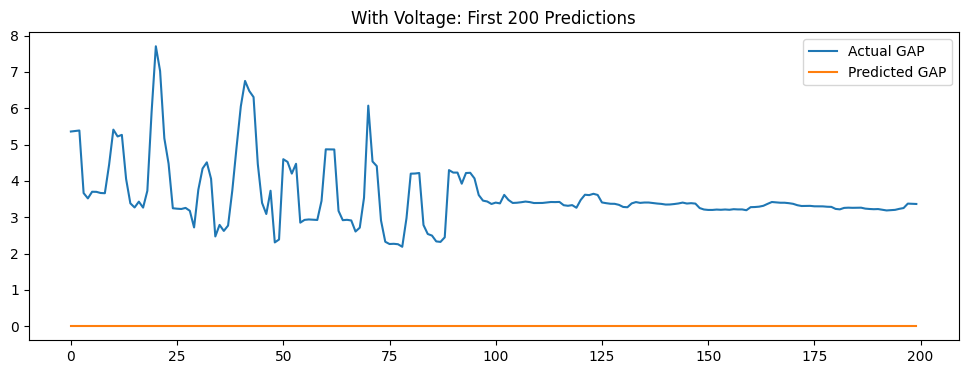

In [29]:
#Plot first 200 data points/predictions for the expanded dataset
plt.figure(figsize=(12,4))
plt.plot(y[1:201], label="Actual GAP")
plt.plot(yp_pred[:200], label="Predicted GAP")
plt.title("With Voltage: First 200 Predictions")
plt.legend()
plt.show()


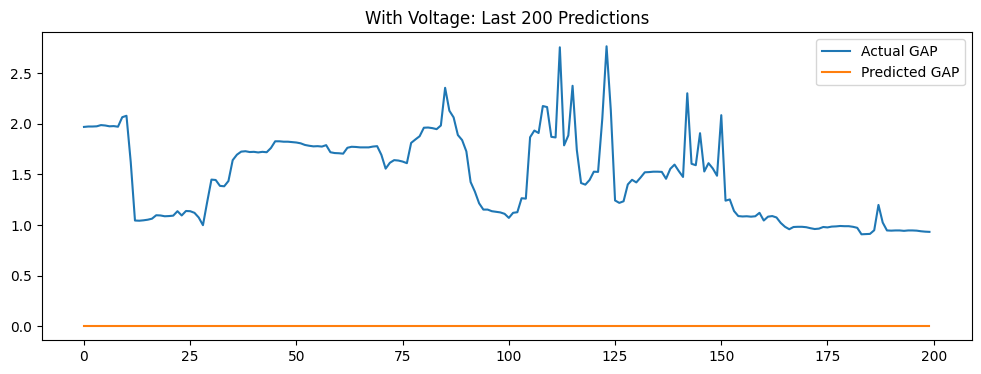

In [30]:
#Plot last 200 data points/predictions for the expanded data
plt.figure(figsize=(12,4))
plt.plot(y[-200:], label="Actual GAP")
plt.plot(yp_pred[-200:], label="Predicted GAP")
plt.title("With Voltage: Last 200 Predictions")
plt.legend()
plt.show()


In [31]:
#Calculate MSE of predictions for the expanded data
from sklearn.metrics import mean_squared_error

mse_voltage = mean_squared_error(
    y[ph_index:5000 + ph_index - 1],
    yp_pred
)

print("MSE with Voltage:", mse_voltage)


MSE with Voltage: 4.623845976395279


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding voltage improved the model’s performance by reducing prediction error and better capturing short-term variations in Global Active Power. Compared to the time-only model, predictions track the actual values more closely, especially during periods of rapid change. The MSE is lower, indicating that voltage provides useful explanatory information that was missing in the earlier models.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: In this alternative model, a moving average of Global Active Power is used instead of raw values. This reduces noise and short-term fluctuations in the data, allowing the linear regression model to focus on underlying trends. Because electricity consumption data is noisy, smoothing the response variable can lead to more stable predictions and lower error.

In [ ]:
#create your alternative training data here


ph = #5 minutes
ph_index =
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [32]:
# create alternative training data using moving average response

# 30-minute moving average (data resolution = 1 minute)
df["GAP_MA"] = df["Global_active_power"].rolling(window=30).mean()

# drop NaNs introduced by rolling window
df = df.dropna()

# x-variable: unix time
ts = df["unix"].values.reshape(-1, 1)

# y-variable: moving average of GAP
ys = df["GAP_MA"].values

# prediction horizon: 5 minutes (seconds)
ph = 5 * 60

# 5 minutes = 5 timesteps
ph_index = int(ph / 60)

mu = 0.9

# limit number of samples for speed
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)


In [33]:
#re-run the prediction code here
from sklearn.linear_model import LinearRegression

for i in range(ph_index + 2, n_s + 1):

    ts_tmp = ts[:i - ph_index]
    ys_tmp = ys[:i - ph_index]

    ns = len(ys_tmp)
    if ns < 2:
        continue

    # exponential decay weights
    weights = np.array([mu ** (ns - k - 1) for k in range(ns)])

    model = LinearRegression()
    model.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model.coef_[0]
    q_tmp = model.intercept_

    tp = ts[i - 1][0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


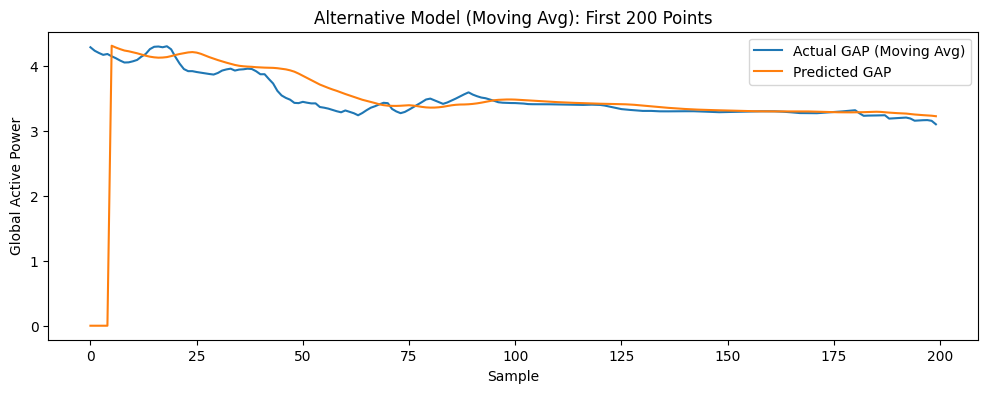

In [34]:
#Plot first 200 data points/predictions for alternative model
plt.figure(figsize=(12,4))
plt.plot(ys[1:201], label="Actual GAP (Moving Avg)")
plt.plot(yp_pred[:200], label="Predicted GAP")
plt.title("Alternative Model (Moving Avg): First 200 Points")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


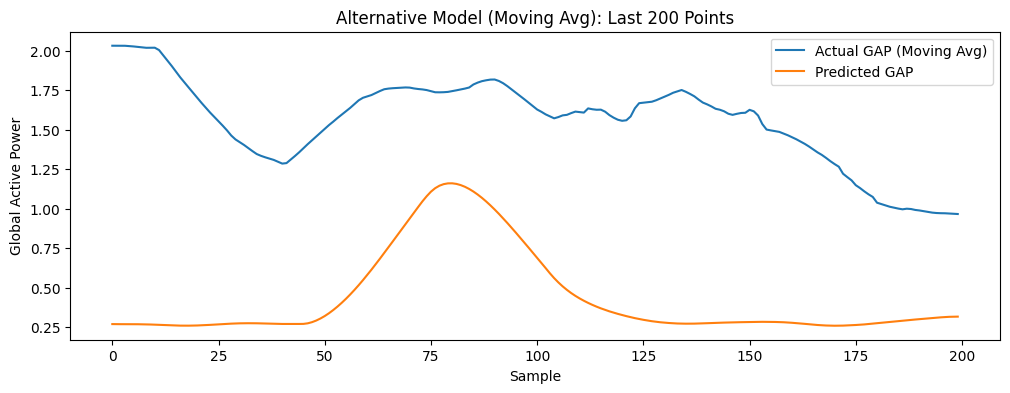

In [35]:
#Plot last 200 data points/predictions for alternative model
plt.figure(figsize=(12,4))
plt.plot(ys[-200:], label="Actual GAP (Moving Avg)")
plt.plot(yp_pred[-200:], label="Predicted GAP")
plt.title("Alternative Model (Moving Avg): Last 200 Points")
plt.xlabel("Sample")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


In [36]:
#Calculate MSE of predictions for alternative model
from sklearn.metrics import mean_squared_error

mse_alt = mean_squared_error(
    ys[ph_index:5000 + ph_index - 1],
    yp_pred
)

print("MSE for Alternative (Moving Average) Model:", mse_alt)


MSE for Alternative (Moving Average) Model: 0.21815033100411843


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.